# <center> Homework 7

In [1]:
#import libraries
import pandas as pd
import numpy as np
import pandas_profiling as pp
import warnings
warnings.simplefilter('ignore')

In [2]:
#input data with index column and rename index column as 'index'
train = pd.read_csv('hw6/data/train.csv', sep='\t').rename(columns={'Unnamed: 0': 'index'})
test = pd.read_csv('hw6/data/test.csv', sep='\t').rename(columns={'Unnamed: 0': 'index'})

In [3]:
#train_report = pp.ProfileReport(train)
#test_report = pp.ProfileReport(test)

In [4]:
#train_report

In [5]:
#test_report

In [6]:
# constant features on the test
conditions = {0:['129', '130', '137', '138', '140', '141', '149', 
                 '150', '164', '178', '186', '188', '192', '193',
                 '291', '301', '303', '305', '5'], 
              1:['11']}
# highly correlated features
redundant_cols = ['9', '160', '152']
# reduntant features
redundant_cols += list(conditions.values())[0] + list(conditions.values())[1]

In [7]:
def get_subframe(df, conditions):
    '''This function returns subframe that meets the conditions'''
    data_ = df.copy()
    for value, columns in conditions.items():
        for column in columns:
            data_ = data_[data_[column]==value]
    return data_

In [8]:
def reindexing(list_):
    '''This function reset index of dataframe columns'''
    size = len(list_)
    res = {}
    for i, column in zip(range(size), list_):
        res.update({column: str(i)})
    return res

In [9]:
# concat train and test datasets in one
train['is_train'] = True
test['is_train'] = False
all_df = pd.concat([train, test])
# delete redundant columns from dataset and reindexing them by columns
all_df.drop(redundant_cols, axis=1, inplace=True)
#all_df.rename(columns=reindexing(all_df.columns[1:-1]), inplace=True)
all_df.head()

,index,0,1,2,3,4,6,7,8,10,...,337,338,339,340,341,342,343,344,345,is_train
0,0,1.0,1,0,0,0,0,0.090909,0,1,...,0,1,0,0,0.222222,1,1,1,1,True
1,1,1.0,1,0,0,1,0,0.090909,0,1,...,0,1,0,0,0.111111,1,1,1,0,True
2,2,0.0,1,0,0,1,0,0.090909,0,1,...,0,1,0,0,0.444444,1,1,1,1,True
3,3,0.0,1,0,0,1,0,0.136364,0,1,...,0,0,1,0,0.222222,1,1,1,0,True
4,4,0.0,1,0,0,1,0,0.136364,0,1,...,0,0,1,0,0.111111,1,1,1,1,True


In [10]:
def get_frames(data, target, is_train, dop_columns=None):
    X_train = data[data[is_train]].drop(dop_columns + [is_train] + [target], axis=1)
    X_test = data[~ data[is_train]].drop(dop_columns + [is_train] + [target], axis=1)
    y_train = data.loc[data[is_train], target]
    return X_train, X_test, y_train

In [11]:
X_train_clear, X_test_clear, y_train = get_frames(all_df, target='0', is_train='is_train', dop_columns=['index'])

### Float part of dataset

In [12]:
def get_part(data, type_='float64', non_feature_cols=[]):
    '''This function selects columns whose datatypes are float64'''
    data_ = data.copy()
    float_cols = [i for i in data_.columns[2:] if np.dtype(data_[i]).name == type_]
    data_ = data_[float_cols + non_feature_cols]
    return data_

In [13]:
floats = get_part(all_df, 
                  type_='float64',
                  non_feature_cols=['is_train', 'index', '0'])

In [14]:
#pp.ProfileReport(floats)

In [15]:
float_categorical = []
for column in floats.columns[:-3]:
    nunique = floats[column].nunique() 
    nunique_train = floats.loc[floats.is_train, column].nunique() 
    nunique_test = floats.loc[~ floats.is_train, column].nunique()
    if nunique < 25: 
        float_categorical.append(column)
        print('\'{}\': {}, train: {}, test: {}'.format(column, 
                                                       nunique, 
                                                       nunique_train, 
                                                       nunique_test))
        

'7': 13, train: 13, test: 10
'106': 21, train: 21, test: 15
'107': 23, train: 23, test: 15
'108': 18, train: 17, test: 14
'117': 5, train: 5, test: 5
'120': 11, train: 11, test: 11
'124': 5, train: 5, test: 5
'127': 10, train: 10, test: 10
'212': 5, train: 5, test: 4
'311': 12, train: 12, test: 12
'312': 12, train: 12, test: 12
'313': 12, train: 12, test: 12
'314': 11, train: 11, test: 11
'315': 12, train: 12, test: 12
'341': 10, train: 10, test: 10


In [16]:
floats.drop(float_categorical, axis=1, inplace=True)

In [17]:
def const_A(column):
    list_ = list(column.drop_duplicates().sort_values())
    if list_[0] < 1e-9:
        return list_[1]
    return list_[0]

In [18]:
float_categorical_df = all_df[['0', 'index', 'is_train']]
for column in float_categorical:
    const = const_A(all_df[column])
    float_categorical_df[column] = all_df[column].apply(
        lambda x: round(7 * x / const ** 1.5))

In [19]:
res = True
for column in float_categorical:
    if  float_categorical_df[column].nunique() != all_df[column].nunique():
        res = False
    print(float_categorical_df[column].max())
res

722
626
772
189
56
675
56
608
29342
1814
28
3246
173
3650
189


True

In [20]:
float_categorical_df.head()

,0,index,is_train,7,106,107,108,117,120,124,127,212,311,312,313,314,315,341
0,1.0,0,True,66,219,134,105,42,405,28,135,29342,237,19,488,101,1247,42
1,1.0,1,True,66,157,168,137,56,405,28,338,29342,152,17,212,85,1639,21
2,0.0,2,True,66,125,67,116,42,338,14,405,29342,706,24,1499,77,288,84
3,0.0,3,True,98,188,134,105,42,608,28,68,29342,237,19,488,101,1247,42
4,0.0,4,True,98,250,134,84,42,540,28,338,29342,237,19,488,101,1247,21


### Binary part of dataset

In [21]:
binaries = get_part(all_df, 
                    type_='int64', 
                    non_feature_cols=['is_train', 'index', '0'])

def subplural(list_, n_):
    res = []
    for i in range(len(list_) - n_ + 1):
        res.append(list_[i: i + n_])
    return res


def drop(list_, redundant_cols):
    return [i for i in list_ if i not in redundant_cols]

all_subplurals = []
for i in range(binaries.shape[1] - 1):
    all_subplurals += subplural(
            list(binaries.columns[:-2]), 
            i + 2)
    
all_subplurals_copy = all_subplurals.copy()

categorical = []
for columns in all_subplurals_copy:
    dt = binaries.loc[binaries.is_train, columns].sum(axis=1)
    if dt.min() == dt.max() == 1:
        categorical.append(columns)
categorical

In [22]:
def new_features(data):
    '''This function concatenates some binary features in one feature'''
    res = ''
    for i in data:
        res += str(i)
    return res

In [23]:
binary_categorical = ['1', '2', '3']
binary_categorical_df = all_df[['0', 'index', 'is_train']]
binary_categorical_df['1_4'] = all_df[binary_categorical].apply(lambda x : int(new_features(x), base=2), axis=1)

In [24]:
binary_categorical_df.head()

,0,index,is_train,1_4
0,1.0,0,True,4
1,1.0,1,True,4
2,0.0,2,True,4
3,0.0,3,True,4
4,0.0,4,True,4


In [25]:
all_df[binary_categorical].head()

,1,2,3
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [26]:
binaries.drop(binary_categorical, axis=1, inplace=True)

In [27]:
binaries.head()

,4,6,8,10,12,14,15,16,17,18,...,338,339,340,342,343,344,345,is_train,index,0
0,0,0,0,1,1,0,0,0,0,0,...,1,0,0,1,1,1,1,True,0,1.0
1,1,0,0,1,1,0,0,0,0,0,...,1,0,0,1,1,1,0,True,1,1.0
2,1,0,0,1,1,0,0,0,0,0,...,1,0,0,1,1,1,1,True,2,0.0
3,1,0,0,1,1,0,0,0,0,0,...,0,1,0,1,1,1,0,True,3,0.0
4,1,0,0,1,1,0,0,0,0,0,...,0,1,0,1,1,1,1,True,4,0.0


In [28]:
X_train_binary, X_test_binary, y_train = get_frames(binaries, target='0', is_train='is_train', dop_columns=['index'])

## Categorical features

In [29]:
all_categorical_df = float_categorical_df.merge(binary_categorical_df.drop('0', axis=1), 
                                                on=['index', 'is_train'], 
                                                how='left')
all_categorical_df.head()

,0,index,is_train,7,106,107,108,117,120,124,127,212,311,312,313,314,315,341,1_4
0,1.0,0,True,66,219,134,105,42,405,28,135,29342,237,19,488,101,1247,42,4
1,1.0,1,True,66,157,168,137,56,405,28,338,29342,152,17,212,85,1639,21,4
2,0.0,2,True,66,125,67,116,42,338,14,405,29342,706,24,1499,77,288,84,4
3,0.0,3,True,98,188,134,105,42,608,28,68,29342,237,19,488,101,1247,42,4
4,0.0,4,True,98,250,134,84,42,540,28,338,29342,237,19,488,101,1247,21,4


In [30]:
X_train_categorical, X_test_categorical, y_train = get_frames(all_categorical_df, 
                                                              target='0', 
                                                              is_train='is_train',
                                                              dop_columns=['index'])

In [31]:
X_train_categorical.shape, X_test_categorical.shape, y_train.shape

((30500, 16), (4166, 16), (30500,))

# XGBoost on float part

In [32]:
from sklearn.model_selection import StratifiedKFold, KFold
skf = StratifiedKFold(n_splits=11, random_state=13)
new_skf = KFold(n_splits=3, random_state=13)

In [33]:
def geometric_mean(df, col1, col2, col3):
    return df[col1] ** df[col2] ** df[col3]

In [34]:
floats_with_features = floats.copy()
#floats_with_features['72_86_91'] = geometric_mean(floats_with_features, 
#                                                '72', '86', '91')

In [35]:
#floats_with_features[['72', '86', '91', '72_86_91']].head()

In [36]:
X_train_float, X_test_float, y_train = get_frames(floats_with_features, target='0', is_train='is_train', dop_columns=['index'])

In [37]:
import xgboost as xgb
xgb_float_train = xgb.DMatrix(X_train_float, y_train, feature_names=X_train_float.columns)
xgb_float_test = xgb.DMatrix(X_test_float, feature_names=X_test_float.columns)

In [38]:
parameters_xgb_1 = {
    #default
    'objective': 'binary:logistic',
    'eta': 0.01,
    'silent': 1,
    "nthread": -1,
    "random_seed": 13,
    "eval_metric": 'auc',
    
    #regularization
    'max_depth':  9,
    'max_leaves': 75,
    'subsample': 0.7, 
    'colsample_bytree': 0.66,

    'tree_method': 'hist',
    'grow_policy': 'lossguide'}

n_rounds = 10000

In [39]:
results_xgb_1 = xgb.cv(parameters_xgb_1,
                xgb_float_train, 
                n_rounds, 
                folds=skf,
                early_stopping_rounds=50, 
                verbose_eval=10,
                seed=13)

[0]	train-auc:0.693441+0.00466326	test-auc:0.654189+0.00679508
[10]	train-auc:0.74818+0.0053248	test-auc:0.687966+0.00888543
[20]	train-auc:0.760016+0.0043948	test-auc:0.69308+0.00908921
[30]	train-auc:0.765964+0.00373224	test-auc:0.69491+0.0101211
[40]	train-auc:0.772042+0.00243813	test-auc:0.696371+0.0100163
[50]	train-auc:0.77599+0.00212153	test-auc:0.697941+0.0102291
[60]	train-auc:0.780307+0.00243796	test-auc:0.698359+0.00938361
[70]	train-auc:0.783957+0.0025287	test-auc:0.6991+0.00954064
[80]	train-auc:0.788192+0.00281465	test-auc:0.700363+0.00933861
[90]	train-auc:0.792079+0.00357095	test-auc:0.701382+0.00906311
[100]	train-auc:0.796423+0.00333492	test-auc:0.702161+0.0088187
[110]	train-auc:0.800246+0.00312741	test-auc:0.703193+0.00877064
[120]	train-auc:0.804325+0.00275116	test-auc:0.704265+0.00885194
[130]	train-auc:0.808093+0.00243357	test-auc:0.704781+0.00868876
[140]	train-auc:0.811675+0.00275405	test-auc:0.705535+0.00865124
[150]	train-auc:0.815991+0.00269282	test-auc:0.70

In [40]:
model_xgb_1 = xgb.train(parameters_xgb_1, 
                        xgb_float_train, 
                        len(results_xgb_1))

In [41]:
import xgbfir
xgbfir.saveXgbFI(model_xgb_1, 
                 feature_names=xgb_float_train.feature_names,
                 OutputXlsxFile='float_part.xlsx'
                )

In [42]:
X_floats = floats.drop(['0', 'is_train', 'index'], axis=1)
xgb_floats =  xgb.DMatrix(X_floats, feature_names=X_floats.columns)
float_predict_feature = model_xgb_1.predict(xgb_floats)

### Some float features

In [43]:
float_agg = all_df[['index', 'is_train']]
cols = list(floats.columns[:-2])
float_agg['float_mean'] = floats[cols].mean(axis=1)
float_agg['float_median'] = floats[cols].median(axis=1)
float_agg['float_std'] = floats[cols].std(axis=1)
float_agg.head()

,index,is_train,float_mean,float_median,float_std
0,0,True,0.323368,0.244962,0.324508
1,1,True,0.317245,0.246762,0.297597
2,2,True,0.278342,0.134856,0.318638
3,3,True,0.323971,0.205593,0.320334
4,4,True,0.313329,0.192571,0.328652


## XGBoost

In [44]:
xgb_clear_train = xgb.DMatrix(X_train_clear, y_train, feature_names=X_train_clear.columns)
xgb_clear_test = xgb.DMatrix(X_test_clear, feature_names=X_test_clear.columns)
parameters_xgb_clear = {
    'objective': 'binary:logistic',
    'eta': 0.01,
    'silent': 1,
    "nthread": 4,
    "random_seed": 13,
    "eval_metric": 'auc',
   
    
    'max_depth':  9,
    'max_leaves': 75,
    'subsample': 0.85, 
    'colsample_bytree': 0.66,

    'tree_method': 'hist',
    'grow_policy': 'lossguide'  
}

n_rounds = 10000

In [45]:
results_xgb_clear = xgb.cv(parameters_xgb_clear,
                xgb_clear_train, 
                n_rounds, 
                folds=skf,
                early_stopping_rounds=30, 
                verbose_eval=10,
                seed=13)

[0]	train-auc:0.7082+0.00627267	test-auc:0.674778+0.002158
[10]	train-auc:0.763726+0.004871	test-auc:0.713438+0.00462608
[20]	train-auc:0.771699+0.00449506	test-auc:0.71772+0.00654559
[30]	train-auc:0.776834+0.00417903	test-auc:0.720035+0.0067991
[40]	train-auc:0.780845+0.00378536	test-auc:0.721129+0.00707012
[50]	train-auc:0.784932+0.00397597	test-auc:0.722541+0.00690123
[60]	train-auc:0.788253+0.00411545	test-auc:0.723303+0.00685949
[70]	train-auc:0.79146+0.00397524	test-auc:0.724437+0.00684465
[80]	train-auc:0.794286+0.00390294	test-auc:0.72499+0.00719827
[90]	train-auc:0.797822+0.00422367	test-auc:0.725667+0.00702821
[100]	train-auc:0.801433+0.00355154	test-auc:0.726414+0.00700107
[110]	train-auc:0.805049+0.00349408	test-auc:0.726881+0.00699456
[120]	train-auc:0.809064+0.00349138	test-auc:0.727706+0.00708447
[130]	train-auc:0.813039+0.00349035	test-auc:0.728759+0.00697669
[140]	train-auc:0.816951+0.00351606	test-auc:0.729181+0.00702166
[150]	train-auc:0.820689+0.00352202	test-auc:0

In [46]:
model_xgb_clear = xgb.train(parameters_xgb_clear, xgb_clear_train, len(results_xgb_clear))

In [47]:
y_test = model_xgb_clear.predict(xgb_clear_test)

In [48]:
def save_submission(prediction, filename):
    '''This function makes a submission files'''
    submission = pd.Series (prediction, name='_VAL_' )
    submission.to_csv(filename, index_label='_ID_', header =True )

In [49]:
save_submission(y_test, 'non_feature.csv')

### Checking

In [50]:
(all_categorical_df.shape[1]  - 1) + (binaries.shape[1] - 3) + (floats.shape[1] - 3) == all_df.shape[1] - 3

True

## Target encoding

In [51]:
# by Stas Semenov

import time
import numpy as np

class SemenovEncoding:
    def __init__(self, C=10):
        self.C = C
        self.cpu_k = 3
        self.global_mean = 0
        self.features = 'all'
        self.cat_columns = []
        self.y = 0
        self.values = dict()

    def fit(self, data, y, features='all '):

        self.y = y
        
        if features == 'all':
            self.cat_columns = sorted([i for i in data.columns if data[i].dtype == 'O'])
            self.features = self.cat_columns
        else:
            self.features = features

        self.global_mean = np.mean(y)

        f = {'y': ['size', 'mean']}

        for col in self.features:
            self.values[col] = dict()
            temp = pd.DataFrame({'y': y, col: data[col]}).groupby([col]).agg(f)

            self.values[col] = (
                (temp['y']['mean'] * temp['y']['size'] + self.global_mean * self.C) / 
                (temp['y']['size'] + self.C)
            ).to_dict()
            
        return self.values

    def fit_transform(self, data, y, features='all', inplace=True):

        self.fit(data, y, features)
        return self.transform(data, inplace=inplace)

    def transform(self, data, inplace=True):
        import warnings

        if inplace:
            for col in self.values:
                if col in data.columns:
                    temp = pd.DataFrame.from_dict(
                        self.values[col], orient='index').reset_index()
                    temp.columns = [col, 'value']
                    data = pd.merge(data, temp, how='left').fillna(self.global_mean)
                    data[col] = data['value']
                    del data['value']
                    data[col] = data[col].astype('float32')

                else:
                    warnings.warn('Column ' + col + ' is missed in this dataset.')
        else:
            new_data = data.copy()
            for col in self.values:
                if col in new_data.columns:
                    temp = pd.DataFrame.from_dict(
                        self.values[col], orient='index').reset_index()
                    temp.columns = [col, 'value']
                    new_data = pd.merge(
                        new_data, temp, how='left').fillna(self.global_mean)
                    new_data[col] = new_data['value']
                    del new_data['value']
                    new_data[col] = new_data[col].astype('float32')

                else:
                    warnings.warn('Column ' + col + ' is missed in this dataset.')
            return new_data
        
def create_new_df_with_categorical_encodings(new_train, new_train_y, new_val, cols, skf):
    se = SemenovEncoding()
    new_skf = skf
    val_dfs = []
    # 2)
    for new_train_split, new_val_split in new_skf.split(new_train, new_train_y):
        # 3)
        se.fit(
            new_train.iloc[new_train_split], 
            new_train_y.iloc[new_train_split], 
            features=cols
        )
        val_dfs.append(
            se.transform(new_train.iloc[new_val_split], inplace=False)
        )
    # 4)
    se.fit(new_train, new_train_y, features=cols)
    main_val = se.transform(new_val, inplace=False)
    return val_dfs, main_val

def target_encoding(X_train, X_test, y_train, skf, feature_names):
    feature_names = list(feature_names)
    new_train_dfs = []
    new_val_dfs = []
    main_train_dfs = []
    for train_split, val_split in skf.split(X_train, y_train): 
        # 5)
        temp_train_dfs, temp_val_df = create_new_df_with_categorical_encodings(
            X_train.iloc[train_split], 
            y_train.iloc[train_split], 
            X_train.iloc[val_split], 
            feature_names,
            skf,
        )
        # 6)
        new_train_dfs.append(temp_train_dfs)
        new_val_dfs.append(temp_val_df)
        # 7)
        se = SemenovEncoding()
        se.fit(X_train.iloc[train_split], y_train.iloc[train_split], feature_names)
        main_train_dfs.append(
            se.transform(X_train.iloc[val_split], inplace=False)
        )
    se.fit(X_train, y_train, features=feature_names)
    main_test = se.transform(X_test, inplace=False)
    main_train = pd.concat(main_train_dfs)
    return pd.concat([main_train, main_test])

In [52]:
target_encoding_categorical_df = all_df[['0', 'index', 'is_train']]
res_target_encoding = target_encoding(X_train_categorical, 
                  X_test_categorical,
                  y_train, 
                  new_skf, 
                  X_train_categorical.columns)
res_target_encoding.reset_index(drop=True, inplace=True)
for column in res_target_encoding.columns:
    target_encoding_categorical_df[column] = res_target_encoding[column]

In [53]:
X_train_categorical.head()

,7,106,107,108,117,120,124,127,212,311,312,313,314,315,341,1_4
0,66,219,134,105,42,405,28,135,29342,237,19,488,101,1247,42,4
1,66,157,168,137,56,405,28,338,29342,152,17,212,85,1639,21,4
2,66,125,67,116,42,338,14,405,29342,706,24,1499,77,288,84,4
3,98,188,134,105,42,608,28,68,29342,237,19,488,101,1247,42,4
4,98,250,134,84,42,540,28,338,29342,237,19,488,101,1247,21,4


In [54]:
target_encoding_categorical_df.head()

,0,index,is_train,7,106,107,108,117,120,124,127,212,311,312,313,314,315,341,1_4
0,1.0,0,True,0.178197,0.173155,0.192347,0.176598,0.176882,0.190261,0.185848,0.183346,0.167859,0.295760,0.295760,0.295760,0.295760,0.295760,0.267679,0.182023
1,1.0,1,True,0.178197,0.183401,0.174600,0.177204,0.154346,0.190261,0.185848,0.217655,0.167859,0.244154,0.244154,0.244154,0.244154,0.244154,0.281963,0.182023
2,0.0,2,True,0.178197,0.180095,0.162168,0.166430,0.176882,0.225674,0.199988,0.221801,0.167859,0.198604,0.198604,0.198604,0.198604,0.198604,0.167017,0.182023
3,0.0,3,True,0.210500,0.183956,0.192347,0.176598,0.176882,0.169702,0.185848,0.131548,0.167859,0.295760,0.295760,0.295760,0.295760,0.295760,0.267679,0.182023
4,0.0,4,True,0.210500,0.189686,0.192347,0.189804,0.176882,0.204083,0.185848,0.217655,0.167859,0.295760,0.295760,0.295760,0.295760,0.295760,0.281963,0.182023


## Dimensionality Reduction

In [55]:
xgb_binary_train = xgb.DMatrix(X_train_binary, y_train, feature_names=X_train_binary.columns)
xgb_binary_test = xgb.DMatrix(X_test_binary, feature_names=X_test_binary.columns)
parameters_xgb_binary = {
    'objective': 'binary:logistic',
    'eta': 0.01,
    'silent': 1,
    "nthread": 4,
    "random_seed": 13,
    "eval_metric": 'auc',
   
    
    'max_depth':  9,
    'max_leaves': 80,
    'subsample': 0.55, 
    'colsample_bytree': 0.66,

    'tree_method': 'hist',
    'grow_policy': 'lossguide'  
}

n_rounds = 10000

results_xgb_binary = xgb.cv(parameters_xgb_binary,
                xgb_binary_train, 
                n_rounds, 
                folds=skf,
                early_stopping_rounds=30, 
                verbose_eval=10,
                seed=13)

[0]	train-auc:0.69751+0.00825389	test-auc:0.682621+0.00370656
[10]	train-auc:0.741336+0.00388055	test-auc:0.713248+0.00463511
[20]	train-auc:0.747983+0.00334476	test-auc:0.716868+0.00628495
[30]	train-auc:0.749977+0.00294418	test-auc:0.717732+0.00655413
[40]	train-auc:0.752405+0.00274136	test-auc:0.718925+0.00607115
[50]	train-auc:0.7547+0.00292422	test-auc:0.719848+0.00557549
[60]	train-auc:0.756768+0.00327688	test-auc:0.72118+0.00527745
[70]	train-auc:0.758511+0.00304494	test-auc:0.722137+0.00536714
[80]	train-auc:0.759936+0.00324507	test-auc:0.722651+0.00523231
[90]	train-auc:0.761248+0.00281384	test-auc:0.72318+0.005327
[100]	train-auc:0.762589+0.00306843	test-auc:0.72347+0.00551042
[110]	train-auc:0.76434+0.00298686	test-auc:0.724058+0.00571565
[120]	train-auc:0.765811+0.0030176	test-auc:0.724807+0.00555533
[130]	train-auc:0.767141+0.00286189	test-auc:0.725327+0.00562351
[140]	train-auc:0.768562+0.00272677	test-auc:0.725847+0.00564715
[150]	train-auc:0.77021+0.0026758	test-auc:0.7

In [56]:
model_xgb_binary = xgb.train(parameters_xgb_binary, xgb_binary_train, len(results_xgb_binary))

### umap

In [57]:
import umap
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

In [58]:
ump = umap.UMAP(n_neighbors=25,
                 min_dist=0.001,
                 metric='yule')
X_train_umap = pd.DataFrame(ump.fit_transform(X_train_binary, y_train), columns=['x', 'y'])
X_test_umap = pd.DataFrame(ump.fit_transform(X_test_binary), columns=['x', 'y'])

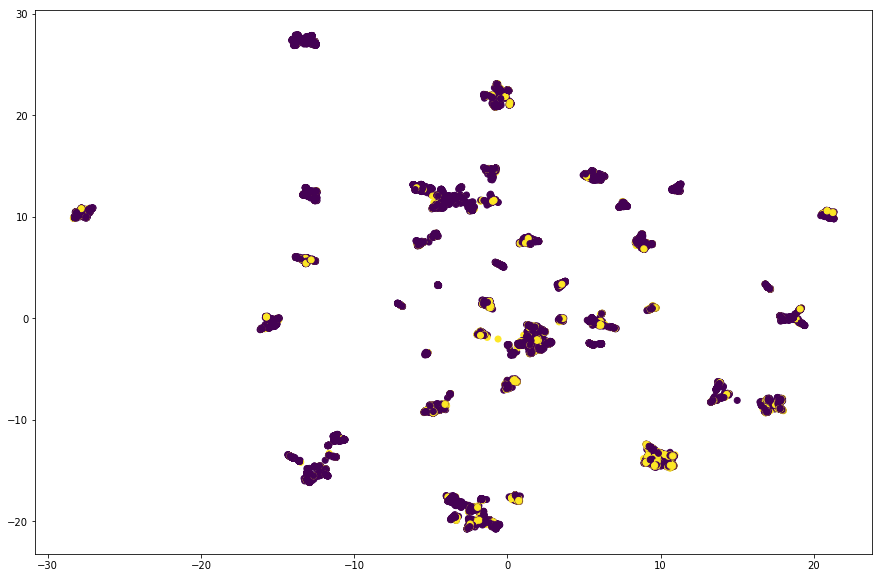

In [59]:
plt.scatter(x=X_train_umap['x'], y=X_train_umap['y'],c=y_train)

In [60]:
all_df_umap = pd.concat([X_train_umap, X_test_umap])
all_df_umap = pd.concat([all_df_umap, binaries], axis=1)
all_df_umap.head()

,x,y,4,6,8,10,12,14,15,16,...,338,339,340,342,343,344,345,is_train,index,0
0,9.094849,-12.459165,0,0,0,1,1,0,0,0,...,1,0,0,1,1,1,1,True,0,1.0
1,-1.523351,1.662090,1,0,0,1,1,0,0,0,...,1,0,0,1,1,1,0,True,1,1.0
2,1.414814,-0.785261,1,0,0,1,1,0,0,0,...,1,0,0,1,1,1,1,True,2,0.0
3,5.458360,-0.365728,1,0,0,1,1,0,0,0,...,0,1,0,1,1,1,0,True,3,0.0
4,9.663887,1.012073,1,0,0,1,1,0,0,0,...,0,1,0,1,1,1,1,True,4,0.0


In [61]:
X_train_binary_umap, X_test_binary_umap, y_train = get_frames(all_df_umap, target='0', is_train='is_train', dop_columns=['index'])

In [62]:
xgb_binary_umap_train = xgb.DMatrix(X_train_binary_umap, y_train, feature_names=X_train_binary_umap.columns)
xgb_binary_umap_test = xgb.DMatrix(X_test_binary_umap, feature_names=X_test_binary_umap.columns)
parameters_xgb_binary_umap = {
    'objective': 'binary:logistic',
    'eta': 0.01,
    'silent': 1,
    "nthread": 4,
    "random_seed": 13,
    "eval_metric": 'auc',
   
    
    'max_depth':  9,
    'max_leaves': 75, 
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'tree_method': 'hist',
    'grow_policy': 'lossguide'  
}

n_rounds = 10000

results_xgb_binary_umap = xgb.cv(parameters_xgb_binary_umap,
                xgb_binary_umap_train, 
                n_rounds, 
                folds=skf,
                early_stopping_rounds=50, 
                verbose_eval=10,
                seed=13)

[0]	train-auc:0.709316+0.00526812	test-auc:0.689322+0.00365431
[10]	train-auc:0.746013+0.00276045	test-auc:0.714628+0.00293342
[20]	train-auc:0.748972+0.00387059	test-auc:0.717639+0.00278934
[30]	train-auc:0.751797+0.00382809	test-auc:0.718378+0.00359675
[40]	train-auc:0.753873+0.00344826	test-auc:0.719895+0.0038782
[50]	train-auc:0.756051+0.00347983	test-auc:0.720913+0.00398385
[60]	train-auc:0.758238+0.00338219	test-auc:0.72155+0.00401796
[70]	train-auc:0.760348+0.00314187	test-auc:0.722309+0.00411349
[80]	train-auc:0.762299+0.00313107	test-auc:0.723+0.00395911
[90]	train-auc:0.764033+0.00305137	test-auc:0.723428+0.00400217
[100]	train-auc:0.765889+0.00295729	test-auc:0.723752+0.00404177
[110]	train-auc:0.767726+0.00296431	test-auc:0.724187+0.00414687
[120]	train-auc:0.769389+0.00309785	test-auc:0.724727+0.00428139
[130]	train-auc:0.771055+0.00330723	test-auc:0.72501+0.00419351
[140]	train-auc:0.772897+0.00344531	test-auc:0.725489+0.00422294
[150]	train-auc:0.774565+0.00338237	test-a

In [63]:
from sklearn.cluster import DBSCAN

In [64]:
dbscan = DBSCAN(eps = 3.0, 
                min_samples=25, 
                n_jobs=4,)

clusters = dbscan.fit_predict(ump.fit_transform(binaries[binaries.columns[:-3]]))

In [65]:
np.unique(clusters).shape

(24,)

In [66]:
binaries_cluster = binaries.copy()
binaries_cluster['umap_dbscan'] = clusters

In [67]:
X_train_binary_cluster, X_test_binary_cluster, y_train = get_frames(binaries_cluster, target='0', is_train='is_train', dop_columns=['index'])

In [68]:
xgb_binary_cluster_train = xgb.DMatrix(X_train_binary_cluster, y_train, feature_names=X_train_binary_cluster.columns)
xgb_binary_cluster_test = xgb.DMatrix(X_test_binary_cluster, feature_names=X_test_binary_cluster.columns)
parameters_xgb_binary_cluster = {
    'objective': 'binary:logistic',
    'eta': 0.01,
    'silent': 1,
    "nthread": 4,
    "random_seed": 13,
    "eval_metric": 'auc',
   
    
    'max_depth':  10,
    'max_leaves': 80, 
    'subsample': 0.55,
    'colsample_bytree': 0.66,

    'tree_method': 'hist',
    'grow_policy': 'lossguide'  
}

n_rounds = 10000

results_xgb_binary_cluster = xgb.cv(parameters_xgb_binary_cluster,
                xgb_binary_cluster_train, 
                n_rounds, 
                folds=skf,
                early_stopping_rounds=50, 
                verbose_eval=10,
                seed=13)

[0]	train-auc:0.698275+0.00952832	test-auc:0.682435+0.00337784
[10]	train-auc:0.742289+0.00406674	test-auc:0.716281+0.00512743
[20]	train-auc:0.747798+0.00345075	test-auc:0.719049+0.00500544
[30]	train-auc:0.751691+0.00319552	test-auc:0.72099+0.00581842
[40]	train-auc:0.753611+0.00311161	test-auc:0.721742+0.00635487
[50]	train-auc:0.755565+0.00274274	test-auc:0.722071+0.0059783
[60]	train-auc:0.757704+0.00281075	test-auc:0.722796+0.00605828
[70]	train-auc:0.759506+0.00264933	test-auc:0.723434+0.00613548
[80]	train-auc:0.761004+0.00257178	test-auc:0.723942+0.0059047
[90]	train-auc:0.762779+0.00268273	test-auc:0.724449+0.00587099
[100]	train-auc:0.764379+0.00247166	test-auc:0.724959+0.00584629
[110]	train-auc:0.766303+0.00268297	test-auc:0.725512+0.00580389
[120]	train-auc:0.767683+0.0025842	test-auc:0.726087+0.00583967
[130]	train-auc:0.769242+0.00249822	test-auc:0.726412+0.00573386
[140]	train-auc:0.770994+0.00279722	test-auc:0.726849+0.00580082
[150]	train-auc:0.772712+0.0027045	test-

### XGBFIR

In [69]:
xgbfir.saveXgbFI(model_xgb_binary, 
                 OutputXlsxFile='binary_part.xlsx',
                 MaxTrees=300, 
                 MaxInteractionDepth=7,
                 feature_names=xgb_binary_train.feature_names)

In [70]:
binaries_xgbfir = binaries.copy()

binaries_xgbfir['338_339'] = binaries[['338', '339']].apply(lambda x: int(new_features(x), base=2), axis=1)
new_column_xgbfir = ['338_339']
binaries_xgbfir.head()

,4,6,8,10,12,14,15,16,17,18,...,339,340,342,343,344,345,is_train,index,0,338_339
0,0,0,0,1,1,0,0,0,0,0,...,0,0,1,1,1,1,True,0,1.0,2
1,1,0,0,1,1,0,0,0,0,0,...,0,0,1,1,1,0,True,1,1.0,2
2,1,0,0,1,1,0,0,0,0,0,...,0,0,1,1,1,1,True,2,0.0,2
3,1,0,0,1,1,0,0,0,0,0,...,1,0,1,1,1,0,True,3,0.0,1
4,1,0,0,1,1,0,0,0,0,0,...,1,0,1,1,1,1,True,4,0.0,1


In [71]:
X_train_binary_xgbfir__, X_test_binary_xgbfir__, y_train = get_frames(binaries_xgbfir, target='0', is_train='is_train', dop_columns=['index'])

In [72]:
tar_enc = target_encoding(X_train_binary_xgbfir__, 
                          X_test_binary_xgbfir__,
                          y_train,
                          new_skf,
                          new_column_xgbfir)
tar_enc.reset_index(drop=True, inplace=True)
for column in new_column_xgbfir:
    binaries_xgbfir[column] = tar_enc[column]

In [73]:
binaries_xgbfir.head()

,4,6,8,10,12,14,15,16,17,18,...,339,340,342,343,344,345,is_train,index,0,338_339
0,0,0,0,1,1,0,0,0,0,0,...,0,0,1,1,1,1,True,0,1.0,0.257016
1,1,0,0,1,1,0,0,0,0,0,...,0,0,1,1,1,0,True,1,1.0,0.257016
2,1,0,0,1,1,0,0,0,0,0,...,0,0,1,1,1,1,True,2,0.0,0.257016
3,1,0,0,1,1,0,0,0,0,0,...,1,0,1,1,1,0,True,3,0.0,0.253421
4,1,0,0,1,1,0,0,0,0,0,...,1,0,1,1,1,1,True,4,0.0,0.253421


In [74]:
X_train_binary_xgbfir, X_test_binary_xgbfir, y_train = get_frames(binaries_xgbfir, target='0', is_train='is_train', dop_columns=['index'])

In [75]:
xgb_binary_xgbfir_train = xgb.DMatrix(X_train_binary_xgbfir, y_train, feature_names=X_train_binary_xgbfir.columns)
xgb_binary_xgbfir_test = xgb.DMatrix(X_test_binary_xgbfir, feature_names=X_test_binary_xgbfir.columns)
parameters_xgb_binary_xgbfir = {
    'objective': 'binary:logistic',
    'eta': 0.01,
    'silent': 1,
    "nthread": 4,
    "random_seed": 13,
    "eval_metric": 'auc',
   
    
    'max_depth':  10,
    'max_leaves': 100, 
    'subsample': 0.66,
    'colsample_bytree': 0.66,
    

    'tree_method': 'hist',
    'grow_policy': 'lossguide'  
}

n_rounds = 10000

results_xgb_binary_xgbfir = xgb.cv(parameters_xgb_binary_xgbfir,
                xgb_binary_xgbfir_train, 
                n_rounds, 
                folds=skf,
                early_stopping_rounds=70, 
                verbose_eval=10,
                seed=13)

[0]	train-auc:0.707013+0.00977296	test-auc:0.686833+0.00576011
[10]	train-auc:0.749146+0.00221296	test-auc:0.717156+0.0058498
[20]	train-auc:0.753737+0.00282331	test-auc:0.71911+0.00474058
[30]	train-auc:0.757475+0.0026185	test-auc:0.720701+0.0053087
[40]	train-auc:0.759855+0.00255227	test-auc:0.721093+0.00571343
[50]	train-auc:0.762051+0.00254978	test-auc:0.721651+0.00613814
[60]	train-auc:0.764153+0.00267852	test-auc:0.722541+0.005966
[70]	train-auc:0.766005+0.00282434	test-auc:0.722807+0.00608385
[80]	train-auc:0.767779+0.00270175	test-auc:0.723377+0.00626004
[90]	train-auc:0.769517+0.00287624	test-auc:0.723931+0.00644827
[100]	train-auc:0.771508+0.00267832	test-auc:0.724459+0.00645741
[110]	train-auc:0.773508+0.00288843	test-auc:0.725034+0.00648279
[120]	train-auc:0.775109+0.00279971	test-auc:0.725336+0.00645322
[130]	train-auc:0.777014+0.00288075	test-auc:0.725732+0.00625995
[140]	train-auc:0.778829+0.00304352	test-auc:0.726171+0.00649913
[150]	train-auc:0.78072+0.00309218	test-au

In [76]:
all_df_concat = binaries_xgbfir.merge(all_categorical_df.drop('0', axis=1),
                                      on=['index', 'is_train'], 
                                      how='left')
all_df_concat = all_df_concat.merge(floats_with_features.drop('0', axis=1),
                                      on=['index', 'is_train'], 
                                      how='left')
all_df_concat = all_df_concat.merge(float_agg,
                                      on=['index', 'is_train'], 
                                      how='left')

In [77]:
X_train_concat, X_test_concat, y_train = get_frames(all_df_concat, target='0', is_train='is_train', dop_columns=['index'])

In [78]:
xgb_concat_train = xgb.DMatrix(X_train_concat, y_train, feature_names=X_train_concat.columns)
xgb_concat_test = xgb.DMatrix(X_test_concat, feature_names=X_test_concat.columns)
parameters_xgb_concat = {
    'objective': 'binary:logistic',
    'eta': 0.01,
    'silent': 1,
    "nthread": 4,
    "random_seed": 13,
    "eval_metric": 'auc',
   
    
    'max_depth':  10,
    'max_leaves': 75,
    'subsample': 0.85,
    'colsample_bytree': 0.7,

    'tree_method': 'hist',
    'grow_policy': 'lossguide'  
}

n_rounds = 10000

results_xgb_concat = xgb.cv(parameters_xgb_concat,
                xgb_concat_train, 
                n_rounds, 
                folds=skf,
                early_stopping_rounds=50, 
                verbose_eval=10,
                seed=13)

[0]	train-auc:0.713345+0.0062458	test-auc:0.676994+0.00563519
[10]	train-auc:0.762151+0.00303193	test-auc:0.713412+0.00543637
[20]	train-auc:0.766452+0.00380788	test-auc:0.717336+0.00703913
[30]	train-auc:0.771297+0.00470922	test-auc:0.719427+0.00673234
[40]	train-auc:0.775068+0.00383122	test-auc:0.720488+0.00709849
[50]	train-auc:0.778328+0.00324875	test-auc:0.721435+0.00700594
[60]	train-auc:0.78219+0.00340635	test-auc:0.722523+0.00689593
[70]	train-auc:0.786395+0.00323436	test-auc:0.723968+0.00693078
[80]	train-auc:0.790465+0.0032278	test-auc:0.724514+0.00721931
[90]	train-auc:0.794481+0.00307088	test-auc:0.725345+0.0074361
[100]	train-auc:0.79871+0.00333779	test-auc:0.726436+0.007451
[110]	train-auc:0.80261+0.00345668	test-auc:0.727073+0.00738544
[120]	train-auc:0.806886+0.00339137	test-auc:0.727896+0.00760404
[130]	train-auc:0.810709+0.00353839	test-auc:0.728667+0.00744005
[140]	train-auc:0.81487+0.00307478	test-auc:0.729559+0.0075576
[150]	train-auc:0.819436+0.00332659	test-auc:0

## Feature Selection

In [79]:
from sklearn.feature_selection import VarianceThreshold
eps = 0.0115
vt = VarianceThreshold(eps).fit(X_train_concat)
X_train_VT = pd.DataFrame(vt.transform(X_train_concat))
X_test_VT = pd.DataFrame(vt.transform(X_test_concat))

In [80]:
X_train_VT.shape, X_test_VT.shape

((30500, 179), (4166, 179))

In [81]:
xgb_concat_train_vt = xgb.DMatrix(X_train_VT, y_train)
xgb_concat_test_vt = xgb.DMatrix(X_test_VT)
parameters_xgb_vt = {
    'objective': 'binary:logistic',
    'eta': 0.01,
    'silent': 1,
    "nthread": 4,
    "random_seed": 13,
    "eval_metric": 'auc',
   
    
    'max_depth':  10,
    'max_leaves': 75,
    'subsample': 0.85,
    'colsample_bytree': 0.66,

    'tree_method': 'hist',
    'grow_policy': 'lossguide'  
}

n_rounds = 10000

results_xgb_concat_vt = xgb.cv(parameters_xgb_vt,
                xgb_concat_train_vt, 
                n_rounds, 
                folds=skf,
                early_stopping_rounds=50, 
                verbose_eval=10,
                seed=13)

[0]	train-auc:0.711588+0.00617982	test-auc:0.677035+0.00186196
[10]	train-auc:0.758798+0.00545701	test-auc:0.714977+0.00492433
[20]	train-auc:0.765618+0.0035536	test-auc:0.718027+0.00645658
[30]	train-auc:0.770002+0.00173507	test-auc:0.719664+0.00723119
[40]	train-auc:0.773327+0.00321593	test-auc:0.721441+0.00644239
[50]	train-auc:0.776717+0.00329968	test-auc:0.722774+0.00641244
[60]	train-auc:0.779925+0.00334412	test-auc:0.723821+0.00621461
[70]	train-auc:0.783106+0.00310869	test-auc:0.724397+0.00620095
[80]	train-auc:0.787251+0.00274336	test-auc:0.725352+0.00603262
[90]	train-auc:0.79106+0.00237159	test-auc:0.726314+0.00596321
[100]	train-auc:0.794285+0.00203199	test-auc:0.727261+0.00562447
[110]	train-auc:0.797906+0.00207226	test-auc:0.727806+0.00560658
[120]	train-auc:0.801538+0.00226019	test-auc:0.728436+0.00596339
[130]	train-auc:0.804842+0.00243415	test-auc:0.729085+0.0060969
[140]	train-auc:0.808608+0.00242841	test-auc:0.729889+0.00643221
[150]	train-auc:0.812272+0.00218841	tes

In [82]:
final_model_xgb = xgb.train(parameters_xgb_vt, xgb_concat_train_vt, len(results_xgb_concat_vt))

In [83]:
y_test_final = final_model_xgb.predict(xgb_concat_test_vt)

In [84]:
save_submission(y_test_final, 'final.csv')

## LightGBM

In [85]:
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
def check_train_score(params, lgb_data, data, target, kf, num_rounds):
    roc_auc = []
    for train, val in kf.split(data,target):
        temp_lgb_train = lgb_data.subset(train) 
        temp_lgb_val = lgb_data.subset(val)
        temp_model = lgb.train(params, temp_lgb_train, num_rounds, verbose_eval=num_rounds)
        roc_auc.append([roc_auc_score(target[train],temp_model.predict(data.loc[train])), roc_auc_score(target[val],temp_model.predict(data.loc[val]))])
    return np.mean(roc_auc, axis=0)

lgb_train = lgb.Dataset(X_train_VT, label=y_train, free_raw_data=False)
parameters_lgb_vt = {
    #default
    'objective': 'binary',
    'learning_rate': 0.01,
    'num_threads': 4,
    "metric": 'auc',
    "seed": 24,
    
    #regularization
    'colsample_bytree': 0.66,
    'subsample': 0.8,
    'subsample_freq': 1,
    'num_leaves': 75,
    'max_depth': 7,
    'min_data_in_leaf' : 15}

n_rounds = 10000

results_lgb_VT = lgb.cv(parameters_lgb_vt,
                lgb_train, 
                n_rounds, 
                folds=skf.split(X_train_VT, y_train), 
                early_stopping_rounds=70, 
                verbose_eval=10)

res = check_train_score(parameters_lgb_vt, lgb_train, X_train_VT, y_train, skf, len(results_lgb_VT['auc-mean']))
on_train = res[0]
on_cv = res[1]
diff = on_train - on_cv
print(on_train, on_cv, diff)

[10]	cv_agg's auc: 0.716824 + 0.00702351
[20]	cv_agg's auc: 0.719931 + 0.00792726
[30]	cv_agg's auc: 0.721165 + 0.00829372
[40]	cv_agg's auc: 0.722448 + 0.00785825
[50]	cv_agg's auc: 0.723757 + 0.00792561
[60]	cv_agg's auc: 0.724619 + 0.0075378
[70]	cv_agg's auc: 0.725304 + 0.00769707
[80]	cv_agg's auc: 0.72626 + 0.00783492
[90]	cv_agg's auc: 0.727217 + 0.00772417
[100]	cv_agg's auc: 0.727945 + 0.00754484
[110]	cv_agg's auc: 0.728652 + 0.00765247
[120]	cv_agg's auc: 0.729257 + 0.00771515
[130]	cv_agg's auc: 0.730107 + 0.0077338
[140]	cv_agg's auc: 0.730884 + 0.00775351
[150]	cv_agg's auc: 0.73153 + 0.00773139
[160]	cv_agg's auc: 0.732117 + 0.00793923
[170]	cv_agg's auc: 0.732942 + 0.00788346
[180]	cv_agg's auc: 0.733597 + 0.00808408
[190]	cv_agg's auc: 0.734458 + 0.0082353
[200]	cv_agg's auc: 0.735081 + 0.00848082
[210]	cv_agg's auc: 0.735741 + 0.00868411
[220]	cv_agg's auc: 0.736362 + 0.00870527
[230]	cv_agg's auc: 0.737124 + 0.00880169
[240]	cv_agg's auc: 0.737987 + 0.00878618
[250]	

In [86]:
model_lgb = lgb.train(parameters_lgb_vt, lgb_train, len(results_lgb_VT['auc-mean']))

In [87]:
test_lgb = model_lgb.predict(X_test_VT)

## Ensemble

In [88]:
lgb_pred_cv = []
xgb_pred_cv = []
for train, val in skf.split(X_train_VT, y_train):
    print('New_fold:', end=' ')
    print('__XGB__', end=' $ ')
    xgb_train_temp = xgb.DMatrix(X_train_VT.iloc[train], y_train[train])
    temp_xgb_model = xgb.train(parameters_xgb_vt, xgb_train_temp , len(results_xgb_concat_vt))
    xgb_pred_cv.append([y_train[val], temp_xgb_model.predict(xgb.DMatrix(X_train_VT.iloc[val]))])
    print('__LGB__')
    lgb_train_temp = lgb.Dataset(X_train_VT.iloc[train], y_train[train])
    temp_lgb_model = lgb.train(parameters_lgb_vt, lgb_train_temp, len(results_lgb_VT['auc-mean']))
    lgb_pred_cv.append([y_train[val], temp_lgb_model.predict(X_train_VT.iloc[val])])

New_fold: __XGB__ $ __LGB__
New_fold: __XGB__ $ __LGB__
New_fold: __XGB__ $ __LGB__
New_fold: __XGB__ $ __LGB__
New_fold: __XGB__ $ __LGB__
New_fold: __XGB__ $ __LGB__
New_fold: __XGB__ $ __LGB__
New_fold: __XGB__ $ __LGB__
New_fold: __XGB__ $ __LGB__
New_fold: __XGB__ $ __LGB__
New_fold: __XGB__ $ __LGB__


In [89]:
scores = {}
for i in range(101):
    iter_1 = 0.01 * i
    iter_2 = 1 - iter_1
    cv_score_weighted_mean = np.mean([roc_auc_score(lgb_p[0],lgb_p[1]* iter_1 + xgb_p[1]* iter_2) for lgb_p, xgb_p in zip(lgb_pred_cv, xgb_pred_cv)])
    scores.update({cv_score_weighted_mean: [iter_1, iter_2]})
best_score = np.array(list(scores.keys())).max()
best_iter_ = scores.get(best_score)
best_score, best_iter_

(0.7513241016802096, [0.6900000000000001, 0.30999999999999994])

In [90]:
y_test_ensemble = 0.69 * test_lgb + 0.31 * y_test_final

In [91]:
save_submission(y_test_ensemble, 'ensemble.csv')